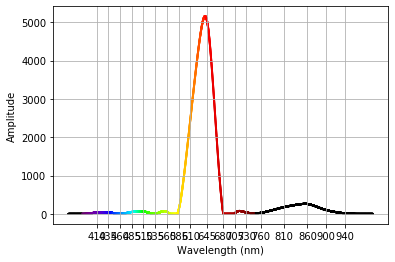

In [4]:
import numpy as np
from scipy.interpolate import Rbf
import matplotlib.pyplot as plt

# https://learn.sparkfun.com/tutorials/spectral-triad-as7265x-hookup-guide
# https://github.com/burubaxair/spectroscopy
channels = np.array([\
410, # A
435, # B
460, # C
485, # D
510, # E
535, # F
560, # G
585, # H
645, # I
705, # J
900, # K
940, # L
610, # R
680, # S
730, # T
760, # U
810, # V
860 # W
])

measurements = np.array([\
38.90,42.00,1.93,51.20,65.59,7.51,58.34,100.62,5074.35,9.59,100.68,16.34,2451.20,40.93,36.35,27.32,176.83,259.36\
]) # red LED

# measurements = np.array([\
# 23.94,209.08,32.88,920.66,98.78,1.50,10.15,9.91,9.46,0.42,1.25,0.96,5.02,0.00,1.86,0.91,3.66,1.22\
# ]) # blue LED

# measurements = np.array([\
# 5.98,6.53,4.83,4.83,4.74,6.01,18.77,210.16,11.52,2.50,5.63,5.77,1055.00,4.20,5.59,7.29,21.07,11.01\
# ]) # orange LED

# measurements = np.array([\
# 41.89,721.52,476.71,328.46,421.19,299.83,404.81,359.35,119.75,13.76,11.26,12.49,526.87,61.92,30.76,17.30,22.91,12.23\
# ]) # white LED

# measurements = np.array([\
# 0.99,2.86,1.84,5.53,8.32,4.28,2.16,5.28,1.71,1.66,106.76,177.44,2.44,12.34,0.96,1.76,11.13,46.55\
# ]) # IR LED

# Sort data in the order of increasing wavelengths
data = np.hstack((channels[:,np.newaxis],measurements[:,np.newaxis]))
data=data[data[:,0].argsort()]

wl = data[:,0].astype(float) # wavelengths
A = data[:,1].astype(float)  # amplitudes


# This function is from https://www.noah.org/wiki/Wavelength_to_RGB_in_Python
def wavelength_to_rgb(wavelength, gamma=0.8):

    '''This converts a given wavelength of light to an 
    approximate RGB color value. The wavelength must be given
    in nanometers in the range from 380 nm through 750 nm
    (789 THz through 400 THz).
    Based on code by Dan Bruton
    http://www.physics.sfasu.edu/astro/color/spectra.html
    '''

    wavelength = float(wavelength)
    if wavelength >= 380 and wavelength <= 440:
        attenuation = 0.3 + 0.7 * (wavelength - 380) / (440 - 380)
        R = ((-(wavelength - 440) / (440 - 380)) * attenuation) ** gamma
        G = 0.0
        B = (1.0 * attenuation) ** gamma
    elif wavelength >= 440 and wavelength <= 490:
        R = 0.0
        G = ((wavelength - 440) / (490 - 440)) ** gamma
        B = 1.0
    elif wavelength >= 490 and wavelength <= 510:
        R = 0.0
        G = 1.0
        B = (-(wavelength - 510) / (510 - 490)) ** gamma
    elif wavelength >= 510 and wavelength <= 580:
        R = ((wavelength - 510) / (580 - 510)) ** gamma
        G = 1.0
        B = 0.0
    elif wavelength >= 580 and wavelength <= 645:
        R = 1.0
        G = (-(wavelength - 645) / (645 - 580)) ** gamma
        B = 0.0
    elif wavelength >= 645 and wavelength <= 750:
        attenuation = 0.3 + 0.7 * (750 - wavelength) / (750 - 645)
        R = (1.0 * attenuation) ** gamma
        G = 0.0
        B = 0.0
    else:
        R = 0.0
        G = 0.0
        B = 0.0

    return (R, G, B)


# https://cdn.sparkfun.com/assets/learn_tutorials/8/3/0/AS7265x_Datasheet.pdf
FWHM=20 

#https://en.wikipedia.org/wiki/Full_width_at_half_maximum
sig=FWHM/(2*np.sqrt(2*np.log(2))) 

# Gaussian function
def g(x,mu):
    return np.exp(-(x-mu)**2/(2*sig**2))

# Interpolate the measurements using radial basis functions

f = Rbf(wl, A, function='multiquadric', epsilon=np.sqrt(2.0)*sig)

x = np.linspace(350,1000,10000)
y = f(x)

y = np.where(y<0, 0.0*y, y)
y = np.where(x <= wl[0], A[0]*g(x,wl[0]), y)
y = np.where(x > wl[-1], A[-1]*g(x,wl[-1]), y)

# Plot the spectrum

colors=[wavelength_to_rgb(wx) for wx in x]

plt.scatter(x,y, color=colors,s=1)
plt.grid()
plt.xlabel("Wavelength (nm)")
plt.ylabel("Amplitude")
plt.savefig('AS7265x_RED.png', format='png', dpi=150)
plt.xticks(wl)


plt.show()